In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data-files/train.csv')
test = pd.read_csv('data-files/test.csv')

In [70]:
print(f'train : {train.shape}\ntest : {test.shape}')
print(f'target col : {train.columns.difference(test.columns)}')

train : (8693, 14)
test : (4277, 13)
target col : Index(['Transported'], dtype='object')


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [72]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [73]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [74]:
# 데이터 합치기
train_id = train['PassengerId'] 
test_id = test['PassengerId']
y = train['Transported']
train = train.drop('Transported', axis=1)
train.shape, test.shape, y.shape

((8693, 13), (4277, 13), (8693,))

In [75]:
all_df = pd.concat([train, test]).reset_index(drop=True)
all_df.shape

(12970, 13)

In [76]:
#결측치 확인
def check_na(data, head_num = 5) :
    isnull_na = (data.isnull().sum()/len(data))*100
    data_na = isnull_na.drop(isnull_na[isnull_na == 0].index).sort_values(ascending = False)
    missing_data = pd.DataFrame({'Missing Ratio' : data_na
                                 , 'Data Type' : data.dtypes[data_na.index]
                                 })
    return print("missing values :\n", missing_data.head(head_num))
    
check_na(all_df)

missing values :
               Missing Ratio Data Type
CryoSleep          2.390131    object
ShoppingMall       2.359291   float64
Cabin              2.305320    object
VIP                2.282190    object
Name               2.266769    object


In [77]:
#문자열 데이터 결측치 처리
cat_vars = list(all_df.select_dtypes(exclude=[np.number]))

for i in cat_vars:
    print(all_df[i].mode()[0])
    all_df[i] = all_df[i].fillna(all_df[i].mode()[0])


0001_01
Earth
False
G/160/P
TRAPPIST-1e
False
Alasmon Meteet


In [78]:
#수치형 데이터 결측치 처리
num_vars = list(all_df.select_dtypes(include=[np.number]))
for i in num_vars:
    print(all_df[i].median())
    all_df[i] = all_df[i].fillna(all_df[i].median())

27.0
0.0
0.0
0.0
0.0
0.0


In [79]:
#왜도
from scipy.stats import skew

skew_features = all_df[num_vars].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

ShoppingMall    11.126048
VRDeck           8.142285
Spa              7.736207
FoodCourt        7.130414
RoomService      6.200653
Age              0.452273
dtype: float64

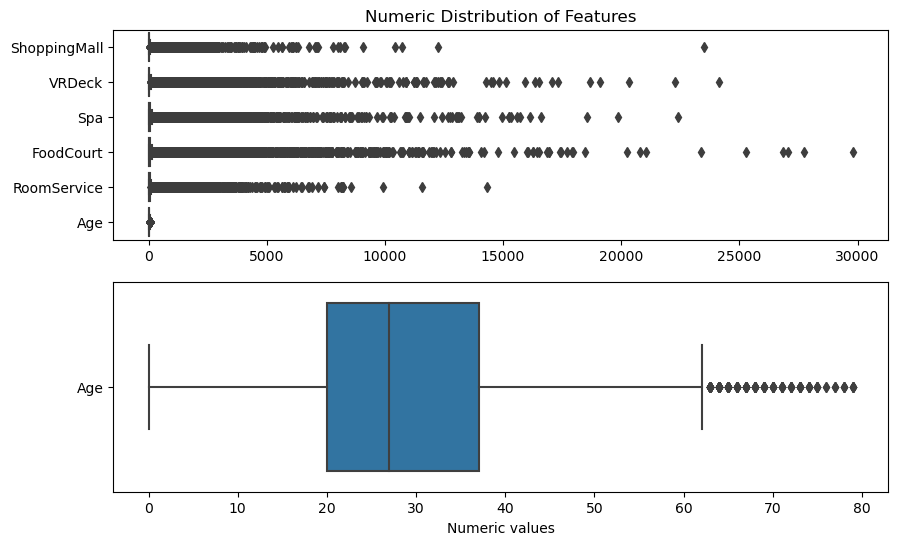

In [80]:
#박스플롯
import matplotlib.pyplot as plt
import seaborn as sns
num_df = all_df.loc[:, skew_features.index]

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.boxplot(data=num_df, orient='h', ax=ax[0])
ax[1].set_xlabel('Numeric values')
ax[0].set_title('Numeric Distribution of Features')

sns.boxplot(data=num_df['Age'], orient='h', ax=ax[1])
ax[1].set_yticklabels(['Age'])
plt.show()

In [81]:
# 문자열 변수 전처리 및 도출 변수(그룹 인원)
print(all_df.select_dtypes(exclude=[np.number]))
group_count = all_df['PassengerId'].str.split('_', expand=True)
group_count.columns = ['GroupCount', 'id']
group_count = group_count.groupby('GroupCount').transform('count')
all_df['GroupCount'] = group_count

cabin = all_df['Cabin'].str.split('/', expand=True)
cabin.columns = ['deck', 'num', 'side']
all_df[['Deck','Num','Side']] = cabin

      PassengerId HomePlanet  ...    VIP               Name
0         0001_01     Europa  ...  False    Maham Ofracculy
1         0002_01      Earth  ...  False       Juanna Vines
2         0003_01     Europa  ...   True      Altark Susent
3         0003_02     Europa  ...  False       Solam Susent
4         0004_01      Earth  ...  False  Willy Santantines
...           ...        ...  ...    ...                ...
12965     9266_02      Earth  ...  False        Jeron Peter
12966     9269_01      Earth  ...  False      Matty Scheron
12967     9271_01       Mars  ...  False        Jayrin Pore
12968     9273_01     Europa  ...  False     Kitakan Conale
12969     9277_01      Earth  ...  False   Lilace Leonzaley

[12970 rows x 7 columns]


In [82]:
# 범주형 더미변수 생성
all_df = pd.get_dummies(all_df, columns=['HomePlanet','Destination','Side'], dummy_na=True)

In [83]:
# Deck는 배에서 층 수를 의미 -> 순서

all_df['Deck'].unique()
ordinal_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
all_df['Deck_encoded'] = all_df['Deck'].map(ordinal_mapping)

In [84]:
all_df = all_df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Deck'])

In [85]:
all_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupCount,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_nan,Side_P,Side_S,Side_nan,Deck_encoded
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,0,False,True,False,False,False,False,True,False,True,False,False,2
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,1,0,True,False,False,False,False,False,True,False,False,True,False,6
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,2,0,False,True,False,False,False,False,True,False,False,True,False,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,2,0,False,True,False,False,False,False,True,False,False,True,False,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1,1,True,False,False,False,False,False,True,False,False,True,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,34.0,False,0.0,0.0,0.0,0.0,0.0,2,1496,True,False,False,False,False,False,True,False,False,True,False,7
12966,False,42.0,False,0.0,847.0,17.0,10.0,144.0,1,160,True,False,False,False,False,False,True,False,True,False,False,7
12967,True,27.0,False,0.0,0.0,0.0,0.0,0.0,1,296,False,False,True,False,True,False,False,False,True,False,False,4
12968,False,27.0,False,0.0,2680.0,0.0,0.0,523.0,1,297,False,True,False,False,False,False,True,False,True,False,False,4


In [86]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
num_vars = all_df.select_dtypes(include=[np.number]).iloc[:,:-2]
all_df[num_vars.columns] = ss.fit_transform(num_vars)

In [87]:
all_df.iloc[:,:12]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupCount,Num,HomePlanet_Earth,HomePlanet_Europa
0,False,0.720932,False,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,1,0,False,True
1,False,-0.332557,False,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1,0,True,False
2,False,2.055350,True,-0.273285,1.998823,-0.292365,5.732776,-0.215170,2,0,False,True
3,False,0.299536,False,-0.340290,0.536429,0.342766,2.706059,-0.091947,2,0,False,True
4,False,-0.894417,False,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,0.369769,False,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,2,1496,True,False
12966,False,0.931629,False,-0.340290,0.258364,-0.263262,-0.260768,-0.133877,1,160,True,False
12967,True,-0.121859,False,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,1,296,False,False
12968,False,-0.121859,False,-0.340290,1.427386,-0.292365,-0.269707,0.190440,1,297,False,True


In [88]:
all_df = all_df.drop(columns='Num')

In [94]:
# boolean 전처리
all_df[all_df.select_dtypes(bool).columns] = all_df.select_dtypes(bool).astype(int)
y = y.astype(int)

In [95]:
X = all_df.iloc[:len(y),:]
X_test = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((8693, 21), (8693,), (4277, 21))

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

classifiers = {
    'LogisticRegression' : LogisticRegression(random_state=42)
    ,'SVC' : SVC(random_state=42, probability=True)
    ,'RandomForest' : RandomForestClassifier(random_state=42)
    ,'LGBM' : LGBMClassifier(random_state=42)
    ,'CatBoost' : CatBoostClassifier(random_state=42, verbose=False)
}

lr_grid = {
    'penalty' : ['l1','l2']
    ,'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5]
    ,'max_iter' : [50, 100, 150]
}

svc_grid = {
    'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5]
    ,'kernel' : ['linear', 'rbf']
    ,'gamma' : ['scale', 'auto']
}

rf_grid = {
    'n_estimators' : [50, 100, 150, 200]
    ,'max_depth' : [4, 8, 12]
}

boosted_grid = {
    'n_estimators' : [50, 100, 150, 200]
    ,'max_depth' : [4, 8, 12]
    ,'learning_rate' : [0.05, 0.1, 0.15]
}

grid = {
    'LogisticRegression' : lr_grid
    ,'SVC' : svc_grid
    ,'RandomForest' : rf_grid
    ,'LGBM' : boosted_grid
    ,'CatBoost' : boosted_grid
}

In [98]:
import time

clf_best_params = classifiers.copy()
val_scores = pd.DataFrame({
    'Classifier' : classifiers.keys()
    ,'Val_acc' : np.zeros(len(classifiers))
    ,'time' : np.zeros((len(classifiers)))
})

for i, (key,classifier) in enumerate(classifiers.items()):
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)
    
    clf.fit(X_train, y_train)
    val_scores.iloc[i, 1] = clf.score(X_val, y_val)
    
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    val_scores.iloc[i, 2] = np.round((stop-start)/60, 2)
    
    print('Model:', key)
    print('Training Time :', val_scores.iloc[i, 2])
    print('')

c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\na1\miniconda3\envs\lee\Lib\site-

Model: LogisticRegression
Training Time : 0.07

Model: SVC
Training Time : 1.13

Model: RandomForest
Training Time : 0.07

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2922, number of negative: 2873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1392
[LightGBM] [Info] Number of data points in the train set: 5795, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504228 -> initscore=0.016912
[LightGBM] [Info] Start training from

In [100]:
clf_best_params

{'LogisticRegression': {'C': 1.5, 'max_iter': 100, 'penalty': 'l2'},
 'SVC': {'C': 1.25, 'gamma': 'auto', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 8, 'n_estimators': 50},
 'LGBM': {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50}}

In [99]:
val_scores

,Classifier,Val_acc,time
0,LogisticRegression,0.783644,0.07
1,SVC,0.783989,1.13
2,RandomForest,0.785024,0.07
3,LGBM,0.791235,0.13
4,CatBoost,0.782609,3.69


In [105]:
from sklearn.model_selection import StratifiedKFold
import timeit

best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params['LGBM'], random_state=42)
    ,"RandomForest" : RandomForestClassifier(**clf_best_params['RandomForest'], random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros(len(X_test))

for key, classifier in best_classifiers.items():
    start = timeit.default_timer()
    score = 0
    
    for fold, (train_i, val_i) in enumerate(cv.split(X, y)):
        X = np.array(X)
        y = np.array(y)
        X_train, X_val = X[train_i], X[val_i]
        y_train, y_val = y[train_i], y[val_i]
        
        clf = classifier
        clf.fit(X_train, y_train)
        
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_val, y_val)

    score = score/5
    stop = timeit.default_timer()
    print('Model :', key)
    print('AVG val acc :', np.round(100*score, 2))
    print('training time :', stop-start)

preds = preds/(5*len(best_classifiers))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1392
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Model : RandomForest
AVG val acc : 79.63
training time : 1.2421146999695338


c:\Users\na1\miniconda3\envs\lee\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [151]:
print('y :', y.sum()/len(y))
print('y_preds :', np.round(preds).sum()/len(preds))


y : 0.5036236051995858
y_preds : 0.5274725274725275


Optimal threshold: 0.509


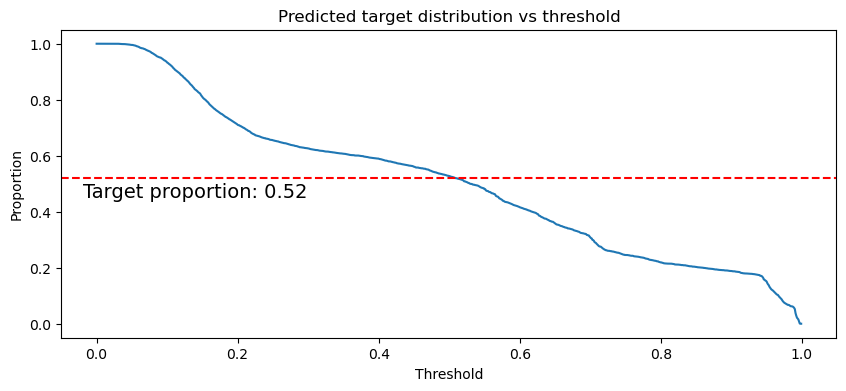

In [153]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.52         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

Text(0.519, 100, 'Optimal Threshold : 0.509')

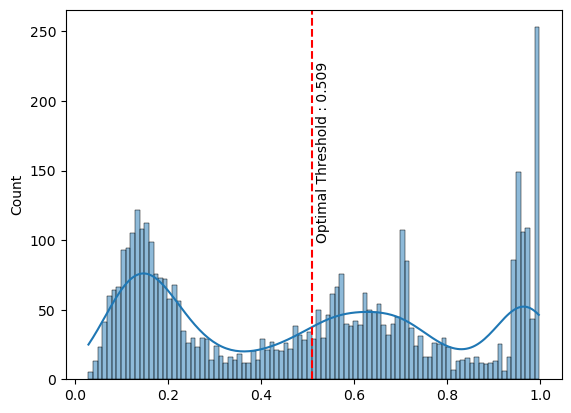

In [154]:
sns.histplot(preds, binwidth=0.01, kde=True)
plt.axvline(x=T_opt, color='r', linestyle='--')
plt.text(T_opt+0.01, 100, f'Optimal Threshold : {T_opt}', rotation=90)

In [164]:
submission = pd.read_csv('data-files/sample_submission.csv')
rows = submission['PassengerId'] != test['PassengerId']
submission[rows]

,PassengerId,Transported


In [167]:
submission['Transported'] = preds >= T_opt

In [178]:
submission.to_csv('submission.csv', index=False)